In [1]:
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift, fftfreq, fft
import matplotlib.pyplot as plt
import math
import imageio  # for GS algorithm test

# Define Propagator Object

In [2]:
class Propagate():
    def __init__(self, wl, dat, x, y, z0):
        self.wl = wl
        self._dat = dat.astype(np.complex128)
        self.ndim = dat.ndim
        self.x = x
        self.y = y
        self.z0 = z0
        self.fx = fftfreq(x.size, x[1] - x[0])[:, np.newaxis]
        self.fy = fftfreq(y.size, y[1] - y[0])[np.newaxis, :]
        
    @property
    def dat(self):
        return np.copy(self._dat)
    
    @dat.setter
    def dat(self, newdat):
        self._dat = np.copy(newdat)
        
    def mask(self, mask):
        self._dat *= mask

    def lens(self, f):
        mask = np.exp(-1j*np.pi*(self.x[:, np.newaxis]**2 + self.y[np.newaxis, :]**2)/(self.wl*f))
        self.mask(mask)
        
    def propagate(self, z):
        kmat = fft2(fftshift(self._dat))
        tf = np.exp(1j*2*np.pi*np.sqrt(1/self.wl**2 - self.fx**2 - self.fy**2 + 0j)*(z - self.z0))
        kmat *= tf
        self._dat = ifftshift(ifft2(kmat))
        return self.dat
        
    def plot(self, fig=None, ax=None, **plotparams):
        if fig is None and ax is None:
            fig, ax = plt.subplots(1)
        ax.imshow(np.abs(self._dat.T)**2, extent=(self.x[0], self.x[-1], self.y[0], self.y[-1]), origin='lower', **plotparams)
        return fig, ax

# Test Propagator (Focus Gaussian beam)

In [5]:
sigma = 1
x = np.linspace(-6*sigma, 6*sigma, 2**8)
y = np.linspace(-6*sigma, 6*sigma, 2**8)
X, Y = np.meshgrid(x, y, indexing='ij')
dat = np.exp(-(X**2 + Y**2)/(2*sigma**2))

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f7c39c9b50>)

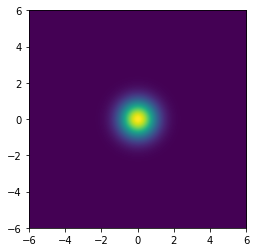

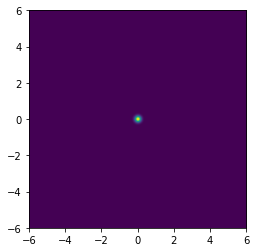

In [6]:
sim = Propagate(0.1, dat, x, y, 0)
sim.plot()
sim.lens(10)
sim.propagate(10)
sim.plot()

# Place aperture in beam

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f7c3c97280>)

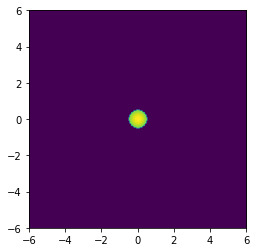

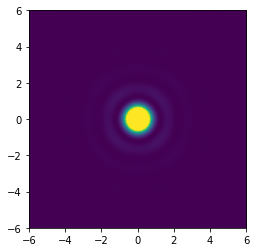

In [7]:
dat_circle = np.copy(dat)
dat_circle[np.sqrt(X**2 + Y**2) > 0.5*sigma] = 0
sim = Propagate(0.1, dat_circle, x, y, 0)
sim.plot()
sim.lens(10)
sim.propagate(10)
sim.plot(clim=(0, 0.2))

# GS Algorithm Proof of Concept

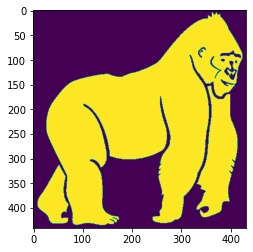

In [7]:
target = ~imageio.imread('Harambe.bmp')
plt.imshow(target)
source = np.ones(target.shape)
source = source/np.sum(np.abs(source)**2)*np.sum(np.abs(target)**2)

In [19]:
Nattempts = 200
target_F = fftshift(target)
source_F = fftshift(source)
target_FT = fft2(target_F)
source_FT = fft2(source_F)
target_A = np.abs(target_FT)
target_P = np.angle(target_FT)
source_A = np.abs(source_FT)
source_P = np.angle(source_FT)
a = ifft2(target_F)
for i in range(Nattempts):
    b = source_F * np.exp(1j*np.angle(a))
    c = fft2(b)
    d = target_F * np.exp(1j*np.angle(c))
    a = ifft2(d)

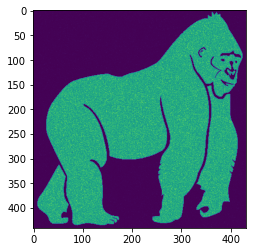

In [20]:
x = ifftshift(fft2(source * np.exp(1j*np.angle(a))))
plt.imshow(np.abs(x)**2)

In [21]:
a_binary = np.copy(a)
a_binary[np.abs(np.angle(a)) < np.pi/2] = 0
a_binary[np.abs(np.angle(a)) > np.pi/2] = -1

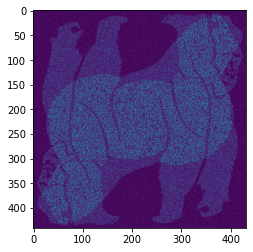

In [22]:
x = ifftshift(fft2(source * np.exp(1j*np.angle(a_binary))))
plt.imshow(np.abs(x)**2)

# Boring stuff

0.9999964237204608
0.04686356708134731
0.0468630014724232


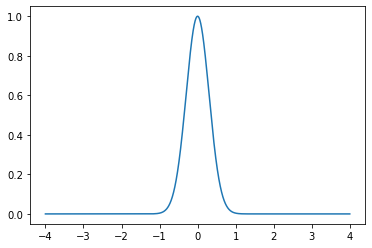

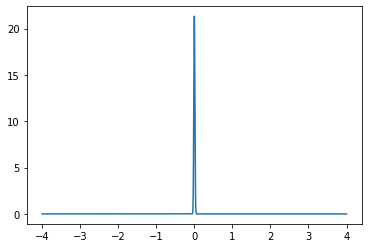

In [85]:
%matplotlib inline
def getfwhm(x, y):
    argmax = np.argmax(y)
    arghalfmax = np.argmin(np.abs(y - np.max(y)/2))
    return 2*np.abs(x[argmax] - x[arghalfmax])
wl = 177e-6
fwhm = 1
f = 300

x = np.linspace(-4*fwhm, 4*fwhm, 2**22)
sigma = fwhm/(2*np.sqrt(2*np.log(2)))
dat_in = np.exp(-x**2/(2*sigma**2))

fx = fftfreq(x.size, x[1] - x[0])
F = (1/wl**2 - fx**2).astype(complex)

dat = np.copy(dat_in).astype(complex)

lens = np.exp(-1j*np.pi*x**2/(wl*f))
otf = np.exp(1j*2*np.pi*np.sqrt(F)*f)
dat *= lens
dat_fft = fft(fftshift(dat))
dat_fft *= otf
dat = ifftshift(ifft(dat_fft))

plt.figure(1)
plt.plot(x, np.abs(dat_in)**2)
dat_fft = fft(fftshift(dat_in))
plt.figure(2)
plt.plot(x, np.abs(dat)**2)

print(getfwhm(x, np.abs(dat_in)))
print(getfwhm(x, np.abs(dat)))

print(4*np.log(2)*wl*f/(np.pi*fwhm))

In [68]:
%matplotlib inline
def getfwhm(x, y):
    argmax = np.argmax(y)
    arghalfmax = np.argmin(np.abs(y - np.max(y)/2))
    return 2*np.abs(x[argmax] - x[arghalfmax])
wl = 177e-6
fwhm = 2
f = 50.4
w = 0.003
d = 0.001

x = np.linspace(-4*fwhm, 4*fwhm, 2**19)
sigma = fwhm/(2*np.sqrt(2*np.log(2)))
dat_in = np.exp(-x**2/(2*sigma**2))

fx = fftfreq(x.size, x[1] - x[0])
F = (1/wl**2 - fx**2).astype(complex)

dat = np.copy(dat_in).astype(complex)

lens = np.exp(-1j*np.pi*x**2/(wl*f))
otf = np.exp(1j*2*np.pi*np.sqrt(F)*(f - d/2))
dat *= lens
dat_fft = fft(fftshift(dat))
dat_fft *= otf
dat = ifftshift(ifft(dat_fft))

aperture = np.zeros(x.size)
aperture[np.abs(x) < w/2] = 1
dz = 1e-4
otf = np.exp(1j*2*np.pi*np.sqrt(F)*dz)
for z in np.ones(int(round(d/dz)))*dz:
    dat *= aperture
    dat_fft = fft(fftshift(dat))
    dat_fft *= otf
    dat = ifftshift(ifft(dat_fft))

otf = np.exp(1j*2*np.pi*np.sqrt(F)*(f - d/2))
dat_fft = fft(fftshift(dat))
dat_fft = otf*dat_fft
dat = ifftshift(ifft(dat_fft))

plt.figure(1)
plt.plot(x, np.abs(dat_in)**2)
dat_fft = fft(fftshift(dat_in))
plt.figure(2)
plt.plot(x, np.abs(dat)**2)

In [69]:
print(getfwhm(x, np.abs(dat_in)**2))
print(getfwhm(x, np.abs(dat)**2))

1.414187267660651
3.0075740958673407


(-0.5, 0.5)

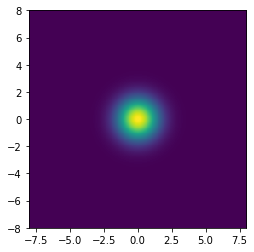

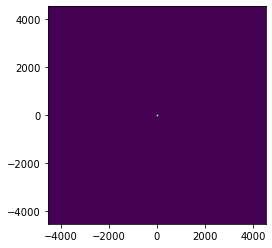

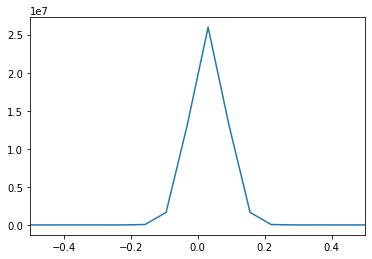

In [111]:
wl = 177e-6
x = np.linspace(-8, 8, 2**8)
y = np.copy(x)
fx = fftfreq(x.size, x[1] - x[0])
fy = fftfreq(y.size, y[1] - y[0])
fwhm = 5
sigma = fwhm/(2*np.sqrt(2*np.log(2)))
r = x[:, np.newaxis]**2 + y[np.newaxis, :]**2
dat_in = np.exp(-r/(2*sigma**2))
f = 10
show_img(np.abs(dat_in)**2, x, y)
dat_fft = ifftshift(fft2(fftshift(dat_in)))
show_img(np.abs(dat_fft)**2, x/(wl*f), y/(wl*f))
idx = np.argmin(np.abs(y))
fig, ax = plt.subplots(1)
ax.plot(x, np.abs(dat_fft[:, idx])**2)
ax.set_xlim([-0.5, 0.5])

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f1b07ed6a0>)

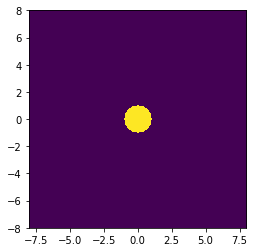

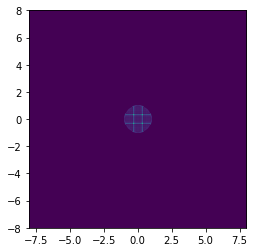

In [12]:
x = np.linspace(-8, 8, 2**10)
y = np.linspace(-8, 8, 2**10)
# fwhm = 3
# sigma = fwhm/(2*np.sqrt(2*np.log(2)))
dat_in = np.zeros((x.size, y.size))
dat_in[np.sqrt(x[:, np.newaxis]**2 + y[np.newaxis, :]**2) < 1] = 1
beam = Propagate(177e-6, dat_in, x, y, 0)
beam.plot()
beam.lens(10)
beam.propagate(10)
beam.plot()

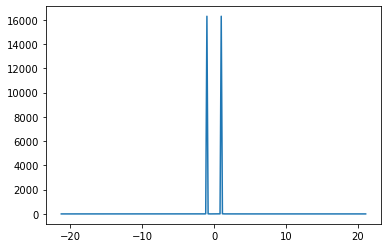

In [25]:
t = np.linspace(-3, 3, 2**8)
y = np.sin(2*np.pi*1*t)
y_fft = np.abs(ifftshift(fft(fftshift(y))))**2
plt.plot(ifftshift(fftfreq(2**8, t[1] - t[0])), y_fft)

In [21]:
print(np.arange(16).reshape(4,4))
print(fftshift(np.arange(16).reshape(4,4)))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[10 11  8  9]
 [14 15 12 13]
 [ 2  3  0  1]
 [ 6  7  4  5]]
